In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math  # for rounding up values
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime  # for strptime
import datetime
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from seaborn import heatmap
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('CR_FC_PREP_0522.csv')
df['POD'] = pd.to_datetime(df['POD'])

df.head()
df.info()
print(f'Dataset size: {df.shape}')


,POD,RATE
0,2005-07-19,2200.0
1,2005-07-20,2250.0
2,2005-07-21,2300.0
3,2005-07-22,2280.0
4,2005-07-23,2260.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6375 entries, 0 to 6374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6375 non-null   datetime64[ns]
 1   RATE    6375 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 99.7 KB
Dataset size: (6375, 2)


In [4]:
df.set_index('POD', inplace=True)
df.head()
df.tail()

,RATE
POD,
2005-07-19,2200.0
2005-07-20,2250.0
2005-07-21,2300.0
2005-07-22,2280.0
2005-07-23,2260.0


,RATE
POD,
2022-12-27,4121.43
2022-12-28,4142.86
2022-12-29,4164.29
2022-12-30,4185.71
2022-12-31,4207.14


<Axes: xlabel='POD'>

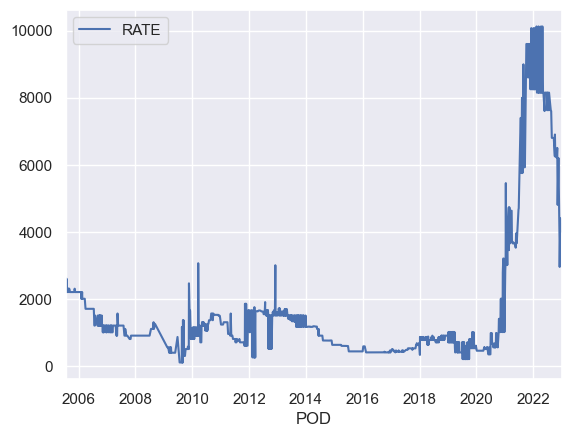

In [5]:
df.plot()

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Fit the Auto ARIMA model
model = pm.auto_arima(df['RATE'], seasonal=True, suppress_warnings=True, error_action="ignore", stepwise=True, trace=True, test='adf')
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=77520.028, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78253.614, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=77746.008, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=77738.545, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78251.664, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=77614.117, Time=1.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=77520.911, Time=1.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=77521.347, Time=2.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=77519.793, Time=2.97 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=77535.593, Time=1.94 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=77461.866, Time=2.89 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=77391.037, Time=4.61 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=77488.005, Time=3.22 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=77449.700, Time=5.51 sec
 ARIMA(4,1,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6375
Model:               SARIMAX(5, 1, 4)   Log Likelihood              -38663.572
Date:                Wed, 22 Mar 2023   AIC                          77347.144
Time:                        08:43:47   BIC                          77414.744
Sample:                    07-19-2005   HQIC                         77370.548
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4235      0.023     61.953      0.000       1.378       1.469
ar.L2         -0.4936      0.051     -9.726      0.000      -0.593      -0.394
ar.L3         -0.8689      0.060    -14.485      0.000      -0.986      -0.751
ar.L4          0.9446      0.038     24.712      0.000       0.870       1.020
ar.L5         -0.1948      0.011    -17.719      0.000      -0.216      -0.173
ma.L1         -1.1580      0.023    -50.617      0.000      -1.203      -1.113
ma.L2          0.0864      0.041      2.111      0.035       0.006       0.167
ma.L3          0.9508      0.038     24.891      0.000       0.876       1.026
ma.L4         -0.7544      0.018    -41.990      0.000      -0.790      -0.719
sigma2      1.117e+04     45.703    244.347      0.000    1.11e+04    1.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):           1953387.58
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               4.82   Skew:                            -1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from datetime import datetime, timedelta

start_date = df.index[-1] + timedelta(days=1)

n_periods = 52

# Create a data frame for the forecast for the next 24 months
index_of_fc = pd.date_range(start=start_date, periods = n_periods+1, freq='D')
fc_df = pd.DataFrame(index=index_of_fc[1:],columns=df.columns)
fc_df.iloc[1:]

fc_df.shape

,RATE
2023-01-03,NaN
2023-01-04,NaN
2023-01-05,NaN
2023-01-06,NaN
2023-01-07,NaN
2023-01-08,NaN
2023-01-09,NaN
2023-01-10,NaN
2023-01-11,NaN
2023-01-12,NaN


(52, 1)

In [20]:
# Forecast the future values
forecast = model.predict(n_periods=n_periods)
forecast_array = forecast.values
print(forecast_array)
print(len(forecast_array))

fc_df['RATE'] = forecast_array
fc_df['RATE'] = fc_df['RATE'].apply(lambda x: round(x, 2))
fc_df.head()

[4190.0719323  4178.34989435 4183.22659526 4200.99697948 4213.7724498
 4211.20219643 4192.68810597 4172.33831994 4163.34800425 4171.76402645
 4188.8746455  4201.27286415 4198.63588176 4183.59738986 4167.24297086
 4162.0546711  4170.9013861  4186.57319579 4196.50424111 4193.50430965
 4180.08314341 4166.91070472 4163.71873389 4172.56921378 4186.09479483
 4193.92500127 4190.25646747 4178.39989274 4167.58186191 4165.98366612
 4174.35906955 4185.98428297 4191.87826574 4187.85112918 4177.33165393
 4168.57370309 4168.10084585 4175.93806019 4185.78471554 4190.12032223
 4185.882001   4176.64878621 4169.60484467 4169.99490038 4177.20099198
 4185.49027277 4188.53923428 4184.26763874 4176.21097678 4170.62800892
 4171.63394571 4178.19260175]
52


,RATE
2023-01-02,4190.07
2023-01-03,4178.35
2023-01-04,4183.23
2023-01-05,4201.00
2023-01-06,4213.77


In [21]:
# After 2023 data to compare accuracy of forecast
df_after = pd.read_csv('CR_FC_PREP_23.csv')
df_after['POD'] = pd.to_datetime(df_after['POD'])

# df_after.set_index('POD',inplace=True)

df_after.head()
df_after.tail()
df_after.info()
print(f'Dataset size: {df_after.shape}')

,POD,RATE
0,2023-01-01,4228.57
1,2023-01-02,4250.00
2,2023-01-03,2800.00
3,2023-01-04,2800.00
4,2023-01-05,2800.00


,POD,RATE
47,2023-02-17,1500.0
48,2023-02-18,1500.0
49,2023-02-19,1500.0
50,2023-02-20,1500.0
51,2023-02-21,1500.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     52 non-null     datetime64[ns]
 1   RATE    52 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 960.0 bytes
Dataset size: (52, 2)


In [22]:
actual_X = df_after.drop("RATE", axis=1)
actual_y = df_after['RATE']

forecast_X = fc_df.drop("RATE", axis=1)
forecast_Y = fc_df['RATE']

In [26]:
from sklearn.metrics import r2_score, median_absolute_error
def findACC(forecast_Y, actual_y):
    # Calculate the accuracy of the model using mean absolute error and R-squared
   mae = median_absolute_error(actual_y, forecast_Y)
   r2 = r2_score(actual_y, forecast_Y)

   print(f"Mean absolute error: {mae:.2f}")
   print(f"R-squared value: {r2:.2f}")

In [27]:
findACC(forecast_Y, actual_y)

Mean absolute error: 1585.49
R-squared value: -5.19
